# Training with variable length with time series parameter set to None gives similar results to our previous architecture

In [18]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
from sklearn.cross_validation import train_test_split

In [19]:
with open('subset1/eng.txt','rt') as f:
    text1 = f.read().lower()
with open('subset1/frn.txt','rt') as f:
    text2 = f.read().lower()
print('corpus length:', len(text1))
print('corpus length:', len(text2))


corpus length: 10746
corpus length: 12009


In [20]:
#generating english model
chars_eng = sorted(list(set(text1)))
chars_fr = sorted(list(set(text2)))
chars = sorted(list(set(chars_eng + chars_fr)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


##training set prepare
maxlen= 10
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])

print('nb sequences:', len(sentences_eng_tr))
##test set prepare
sentences_eng_test = []
string_eng_test= []
step_test=20
for i in range(int(0.8*len(text1)) - maxlen,len(text1) - maxlen-step_test, step_test):
    sentences_eng_test.append(text1[i: i + maxlen])
    string_eng_test.append(text1[i+maxlen:i+maxlen+5])
print('nb sequences:', len(sentences_eng_test))

print('Vectorization...')
X_eng = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng[i, t, char_indices[char]] = 1
    y_eng[i, char_indices[next_chars_eng_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(None, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

total chars: 44
nb sequences: 8586
nb sequences: 107
Vectorization...
Build model...


In [21]:
#generating french model



##training set prepare
maxlen= 10
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

print('nb sequences:', len(sentences_fr_tr))
##test set prepare
sentences_fr_test = []
string_fr_test= []
step_test=20
for i in range(int(0.8*len(text2)) - maxlen,len(text2) - maxlen, step_test):
    sentences_fr_test.append(text2[i: i + maxlen])
    string_fr_test.append(text2[i+maxlen:i+maxlen+5])
print('nb sequences:', len(sentences_fr_test))

print('Vectorization...')
X_fr = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr[i, t, char_indices[char]] = 1
    y_fr[i, char_indices[next_chars_fr_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(None, len(chars))))
model2.add(Dense(len(chars)))
model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

nb sequences: 9597
nb sequences: 121
Vectorization...
Build model...


In [22]:
def vectorize(sentence, chars , char_indices ):
    
    X = np.zeros((1, len(sentence), len(chars)), dtype=np.bool)
    for t, char in enumerate(sentence):
        X[0, t, char_indices[char]] = 1
    return X

In [23]:
def get_scores_for_model(seed,next_string, model,chars,char_indices):
    sentence =seed
    prob_char=0.0
    x = np.zeros((5, maxlen, len(chars)))

    x[0] = vectorize(seed,chars,char_indices)
    x[1] = vectorize(seed[1:]+next_string[:1],chars,char_indices)
    x[2] = vectorize(seed[2:]+next_string[:2],chars,char_indices)
    x[3] = vectorize(seed[3:]+next_string[:3],chars,char_indices)
    x[4] = vectorize(seed[4:]+next_string[:4],chars,char_indices)
    probs_term = []
    for i in range(5):
        preds = model.predict(x[i].reshape(1,40,44), verbose=0)[0]
        preds = np.log(preds)
        probs_term.append(preds[char_indices[next_string[i]]])

    return probs_term
        

In [24]:
def get_scores_for_model_2(seed,next_string, model,chars,char_indices):
    sentence =" "
    prob_char=0.0
    maxlen = len(sentence)
    x = np.zeros((1, maxlen, len(chars)))
    y = np.zeros((1, maxlen+1, len(chars)))
    z = np.zeros((1, maxlen+2, len(chars)))
    a = np.zeros((1, maxlen+3, len(chars)))
    b = np.zeros((1, maxlen+4, len(chars)))

    x = vectorize(seed,chars,char_indices)
    y = vectorize(seed+next_string[:1],chars,char_indices)
    z = vectorize(seed+next_string[:2],chars,char_indices)
    a = vectorize(seed+next_string[:3],chars,char_indices)
    b = vectorize(seed+next_string[:4],chars,char_indices)
    probs_term = []
    
    preds = model.predict(x.reshape(1,maxlen,44), verbose=0)[0]
    preds = np.log(preds)
    probs_term.append(preds[char_indices[next_string[0]]])
    
    preds = model.predict(y.reshape(1,maxlen+1,44), verbose=0)[0]
    preds = np.log(preds)
    probs_term.append(preds[char_indices[next_string[1]]])
    
    preds = model.predict(z.reshape(1,maxlen+2,44), verbose=0)[0]
    preds = np.log(preds)
    probs_term.append(preds[char_indices[next_string[2]]])

    preds = model.predict(a.reshape(1,maxlen+3,44), verbose=0)[0]
    preds = np.log(preds)
    probs_term.append(preds[char_indices[next_string[3]]])

    preds = model.predict(b.reshape(1,maxlen + 4,44), verbose=0)[0]
    preds = np.log(preds)
    probs_term.append(preds[char_indices[next_string[4]]])

    return probs_term
    '''
    prob_list.append(term_probs)
    
    for i in range(5):
        x = np.zeros((1, len(seed), len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        #print('Preds', preds)
        diversity = 1.0
        #print(seed, "\n", next_string)
        prob_char = prob_char + sample(preds, diversity,next_string[i],char_indices)
        sentence = sentence[1:] + next_string[i]
    '''
    return np.exp(prob_char)

In [25]:
print('Vectorization...')
maxlen= 9
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])

X_eng1 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng1 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng1[i, t, char_indices[char]] = 1
    y_eng1[i, char_indices[next_chars_eng_tr[i]]] = 1

maxlen= 8
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng2 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng2 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng2[i, t, char_indices[char]] = 1
    y_eng2[i, char_indices[next_chars_eng_tr[i]]] = 1


maxlen= 7
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng3 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng3 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng3[i, t, char_indices[char]] = 1
    y_eng3[i, char_indices[next_chars_eng_tr[i]]] = 1

    
maxlen= 6
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng4 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng4 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng4[i, t, char_indices[char]] = 1
    y_eng4[i, char_indices[next_chars_eng_tr[i]]] = 1
    
maxlen= 5
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng5 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng5 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng5[i, t, char_indices[char]] = 1
    y_eng5[i, char_indices[next_chars_eng_tr[i]]] = 1
    
maxlen= 4
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng6 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng6 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng6[i, t, char_indices[char]] = 1
    y_eng6[i, char_indices[next_chars_eng_tr[i]]] = 1

maxlen= 3
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng7 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng7 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng7[i, t, char_indices[char]] = 1
    y_eng7[i, char_indices[next_chars_eng_tr[i]]] = 1
    
maxlen= 2
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng8 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng8 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng8[i, t, char_indices[char]] = 1
    y_eng8[i, char_indices[next_chars_eng_tr[i]]] = 1
    
maxlen= 1
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])
X_eng9 = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng9 = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng9[i, t, char_indices[char]] = 1
    y_eng9[i, char_indices[next_chars_eng_tr[i]]] = 1

Vectorization...


In [26]:
import csv
# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a1=model.fit(X_eng, y_eng,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng1, y_eng1,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng2, y_eng2,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng3, y_eng3,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng4, y_eng4,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng5, y_eng5,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng6, y_eng6,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng7, y_eng7,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng8, y_eng8,
              batch_size=128,
              epochs=5)
    a1=model.fit(X_eng9, y_eng9,
              batch_size=128,
              epochs=5)
    model_eng_json = model.to_json()
    with open("model/model_eng_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_eng_json)
    # serialize weights to HDF5
    model.save_weights("weights/model_eng_"+ str(iteration) +".h5")
    print("Saved model to disk")

    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    
    #sentence=
    prob_english=[]
    for i in range(len(sentences_eng_test)):
        prob_english.append(get_scores_for_model_2(" ", string_eng_test[i], model,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_english.append(get_scores_for_model_2(" ", string_fr_test[i], model, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)

    with open("prob_eng/output_prob_" + str(iteration) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        for row in prob_english:
            w.writerow(row)
    with open("model/loss_eng" + ".csv", 'a') as f:
        w = csv.writer(f, dialect='excel')
        w.writerow(a1.history['loss'])
       
        #print()


Iteration 1
Epoch 1/5
8586/8586 [==============================] - 5s - loss: 2.8396 - acc: 0.2059          

In [28]:
print('Vectorization...')
maxlen= 9
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr1 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr1 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr1[i, t, char_indices[char]] = 1
    y_fr1[i, char_indices[next_chars_fr_tr[i]]] = 1

maxlen= 8
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr2 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr2 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr2[i, t, char_indices[char]] = 1
    y_fr2[i, char_indices[next_chars_fr_tr[i]]] = 1


maxlen= 7
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr3 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr3 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr3[i, t, char_indices[char]] = 1
    y_fr3[i, char_indices[next_chars_fr_tr[i]]] = 1

    
maxlen= 6
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr4 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr4 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr4[i, t, char_indices[char]] = 1
    y_fr4[i, char_indices[next_chars_fr_tr[i]]] = 1
    
maxlen= 5
step=1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr5 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr5 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr5[i, t, char_indices[char]] = 1
    y_fr5[i, char_indices[next_chars_fr_tr[i]]] = 1
    
maxlen= 4
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr6 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr6 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr6[i, t, char_indices[char]] = 1
    y_fr6[i, char_indices[next_chars_fr_tr[i]]] = 1

maxlen= 3
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr7 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr7 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr7[i, t, char_indices[char]] = 1
    y_fr7[i, char_indices[next_chars_fr_tr[i]]] = 1
    
maxlen= 2
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr8 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr8 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr8[i, t, char_indices[char]] = 1
    y_fr8[i, char_indices[next_chars_fr_tr[i]]] = 1
    
maxlen= 1
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

X_fr9 = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr9 = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr9[i, t, char_indices[char]] = 1
    y_fr9[i, char_indices[next_chars_fr_tr[i]]] = 1

Vectorization...


In [29]:

import csv
# train the model, output generated text after each iteration


for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a2=model2.fit(X_fr, y_fr,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr1, y_fr1,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr2, y_fr2,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr3, y_fr3,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr4, y_fr4,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr5, y_fr5,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr6, y_fr6,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr7, y_fr7,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr8, y_fr8,
              batch_size=128,
              epochs=5)
    a2=model2.fit(X_fr9, y_fr9,
              batch_size=128,
              epochs=5)
    model_fr_json = model2.to_json()
    with open("model/model_fr_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_fr_json)
    # serialize weights to HDF5
    model2.save_weights("weights/model_fr_"+ str(iteration) +".h5")
    print("Saved model to disk")

        
    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    #sentence=
    prob_fr=[]
    for i in range(len(sentences_eng_test)):
        prob_fr.append(get_scores_for_model_2(" ", string_eng_test[i], model2,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model_2(" ", string_fr_test[i], model2, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)
    with open("prob_fr/output_prob_" + str(iteration) + ".csv", 'wt') as f:
        w = csv.writer(f, dialect='excel')
        for row in prob_fr:
            w.writerow(row)
    with open("model/loss_fr" + ".csv", 'a') as f:
        w = csv.writer(f, dialect='excel')
        w.writerow(a2.history['loss'])

    #print()


Iteration 1
Epoch 1/5
9597/9597 [==============================] - 5s - loss: 1.7243 - acc: 0.4692     

/Users/akankshabindal/anaconda/envs/env/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log
/Users/akankshabindal/anaconda/envs/env/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log
/Users/akankshabindal/anaconda/envs/env/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


In [30]:
def predict_language(prob_english, prob_fr):
    y = [1] * len(prob_english)
    probs_eng = []
    probs_frn = []
    for i in range(len(prob_english)):
        sum_english = 0
        sum_fr = 0
        for j in range(len(prob_english[0])):
            sum_english += float(prob_english[i][j])
            sum_fr += float(prob_fr[i][j])
        sum_english = np.exp(sum_english)
        sum_fr = np.exp(sum_fr)
        if sum_english < sum_fr:
            y[i] = 0
        if sum_fr == 0.0:
            sum_fr = 0.0000000001
            #print(str(i) + "Zero")
        probs_eng.append(sum_english)
        probs_frn.append(sum_fr)
    return y, probs_eng, probs_frn

----------------- Iteration: 1 --------------------
8.12911638448e-24 0.0119355182193
[[76 24]
 [21 79]]
0.775


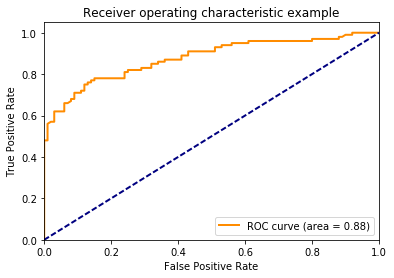

In [31]:
import csv
for iter in range(1,2):
    print("----------------- Iteration: " + str(iter) + " --------------------")
    prob_english=[]
    with open("prob_eng/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_english = list(w)

    prob_fr=[]
    with open("prob_fr/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_fr = list(w)
    
    #print((prob_english), len(prob_fr))
    true_labels = ([1] * 100) + ([0] * 100)
    #print(true_labels.shape)

    from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, auc, roc_curve
    #try:
    pred_y, logprob_english, logprob_fr = predict_language(prob_english, prob_fr)
    #except:
    #    continue
    #x = [e for i, e in enumerate(logprob_fr) if e == 0]
    #print(x)
    print(min(logprob_fr), max(logprob_fr))
    y_hat = np.array([a/b for (a, b) in zip(logprob_english, logprob_fr)])
    #roc_auc_score(true_labels, y_hat)
    
    print (confusion_matrix(true_labels, pred_y))
    print (accuracy_score(true_labels, pred_y))
    #print (y_hat)
    try:
        fpr, tpr, _ = roc_curve(true_labels, y_hat)
    except:
        continue
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()